In [2]:
from numpy import linspace
import numpy as np
import scipy
import scipy.optimize
from cmath import *

import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors

def get_cmap(N):
    '''Returns a function that maps each index in 0, 1, ... N-1 to a distinct 
    RGB color.'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

# Paramaters calc

8.0

In [85]:
#Defenition of all matrices/params
pi = 3.14159265359
hbar = 1.054e-34
fi_0 = 2.07e-15/2/np.pi

#ALSO - mb add non-Jos inductance?

j_c = 0.4e-6#A/um**2
c_J = 50e-15#F/um**2
area = 20. #um**2

C_J = c_J * area#0.4e-12#0.8e-12
I_J =  j_c * area#8e-6
L_J = fi_0 / I_J
E_J = fi_0**2 / L_J
 
N = 1000#300#80
    
C_out = 20e-15
C_0 = 5e-15

print(I_J*1e6, 'uA')
print(C_J*1e12, 'pF')
print('C_J/C_0 = ', C_J / C_0)
print('Z_res = ', (L_J / C_0)**.5)
#print(L_J*1e9, 'nH')
print((C_J*L_J)**(-0.5) /6.28e9, 'GHz')
################################

C = []
L = []# ^-1

for i in range(N+1):
    C.append([])
    L.append([])
    for j in range(N+1):
        if ((i==0)&(j==0)):
            #L[i].append(1./L_J) #lambda/2 
            #C[i].append(C_J)    #lambda/2
            L[i].append(2./L_J)
            C[i].append(2*C_J + C_0)
            continue
        
        if ((i==N)&(j==N)):
            L[i].append(1./L_J) #correctr
            C[i].append(C_J + C_out)
            #L[i].append(2./L_J)
            continue
            
        if (i==j):
            L[i].append(2./L_J)
            C[i].append(2*C_J + C_0)
            continue
            
        if ((j==i+1)or(j==i-1)):
            L[i].append(-1./L_J)
            C[i].append(-C_J)
            continue
        L[i].append(0.)
        C[i].append(0.)

L = np.array(L)
C_inv = scipy.linalg.inv(np.array(C))

8.0 uA
1.0 pF
C_J/C_0 =  200.0
Z_res =  90.75388864949856
24.813619093041716 GHz


In [91]:
C_inv_sqrt= np.mat(scipy.linalg.sqrtm(C_inv))
L_m = np.mat(L)

A=C_inv_sqrt*L*C_inv_sqrt

(freqs,psi) = scipy.linalg.eigh(A,overwrite_a=True)

mode = np.sqrt(freqs)
nums = linspace(1,N+1, N + 1)

plt.plot(nums,(mode)/2/np.pi/1e9,'ro')
plt.xlim(0,10)
plt.show()

In [92]:
modeNumber = 3

def Phi(k):#Correct??????
    return(C_inv_sqrt*psi *np.sqrt(hbar)/mode[k]**0.5)


psi_norm = C_inv_sqrt* psi 

psi_arr = np.array(psi.T)


phase_norm_luca = np.array((psi_norm * ((2*np.pi)/fi_0)*np.sqrt(hbar)/2/np.array(mode)**0.5).T) #Luca's numbers

phase_norm_quanta = np.array((psi_norm * ((2*np.pi)*fi_0)**-1 *np.sqrt(hbar)/2/np.array(mode)**0.5).T)

plt.plot(nums,(phase_norm_quanta[modeNumber]),'ro', label = 'F/F_0')
#plt.plot(nums,(phase_norm_luca[modeNumber]),'ro', label = 'Luca')

plt.legend(loc = 'best')
#plt.plot(nums,psi_arr[0],'ro')
plt.show()
#print freqs[]**0.5/6.28e9

# Going for continious calcilations

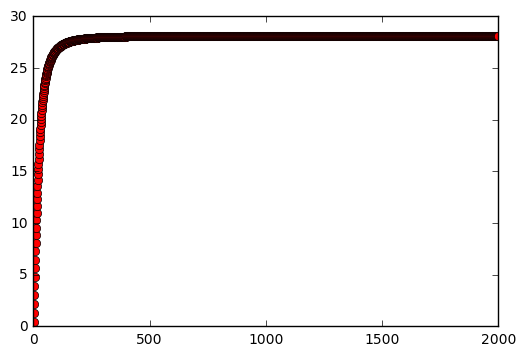

In [5]:
n = linspace(0, N-1, N)
fr = []

def ka(n):
    return( (n + .5) * pi / N )


#def fun(k):
#    return( (2*L_J / pi**2 * (0.5*C_0*N**2 /k**2 + 0.5* pi**2*C_J ) )**-0.5)
def mode_freq(k):
    return ( (L_J * C_J + C_0 * L_J / ka(k)**2)**-0.5 )
              
plt.plot(n+1, mode_freq(n)/6.28e9, 'ro')
fr = mode_freq(n)
#plt.xlim(0,10)
#plt.ylim(8.,12.)
plt.show()

In [6]:
def L(i):
    return(2.*L_J/N / ka(i)**2)

def eta_K(i,j,k,l):
    def function(t):
        return( np.cos(N*ka(i)*t) * np.cos(N*ka(j)*t) *np.cos(N*ka(k)*t) *np.cos(N*ka(l)*t) )
    return( scipy.integrate.quad(function, 0., 1.)[0])

def K(i,j,k,l):
    buf =  -  N * ka(i)*ka(j)*ka(k)*ka(l)* eta_K(i,j,k,l) / 24. / L_J/ fi_0**2 * 2#*2 due to 1/2 in the hamiltonian
    buf = buf * (0.5*hbar)**2 * (L(i) * mode_freq(i))**0.5 * (L(j) * mode_freq(j))**0.5 *(L(k) * mode_freq(k))**0.5 *(L(l) * mode_freq(l))**0.5
    return buf/ hbar * 2.

In [7]:
idler_mode = 14
signal_mode = 15

s = signal_mode
i = idler_mode

K_ssss = K(s,s,s,s)
K_iiii = K(i,i,i,i)
K_sssi = K(s,s,s,i)
K_ssii = K(s,s,i,i)
K_iiis = K(i,i,i,s)

print(K_ssss/1e3, K_iiii/1e3)
print(K_ssii/1e3)
print(K_sssi/1e3,K_iiis/1e3)

-7.270628792549026 -6.518764156852184
-4.589626679112418
5.105565858323627e-15 5.7020859036487454e-15


## Kerr coeffs from discrete Hamiltonian

In [93]:
alpha =  - 0.5* hbar/(24. * L_J * fi_0**2) 

bla = np.array(C_inv_sqrt)

def eta_inside(x,j):
    A=bla[x+1]
    B=bla[x]
    C=np.array(psi_arr)[j]
    D=np.sqrt(C_J)*(A-B)*C
    return np.sum(D)


def eta(j,k,l,m):
    A=[eta_inside(x,j) * eta_inside(x,k) * eta_inside(x,l) * eta_inside(x,m) for x in range(N)]
    return np.sum(A)


def beta(j,k,l,m):
    return(-np.abs(alpha *eta(j,k,l,m) / np.sqrt(mode[j]) / np.sqrt(mode[k]) / np.sqrt(mode[l])/ np.sqrt(mode[m])/ C_J**2))

In [94]:
idler_mode = 7
signal_mode = 8

s = signal_mode
i = idler_mode

K_ssss = beta(s,s,s,s)
K_iiii = beta(i,i,i,i)
K_sssi = beta(s,s,s,i)
K_ssii = beta(s,s,i,i)
K_iiis = beta(i,i,i,s)

print(K_ssss/1e3, K_iiii/1e3)
print(K_ssii/1e3)
print(K_sssi/1e3,K_iiis/1e3)

-3.73133467445 -2.98692073836
-2.22268669074
-0.00945043872154 -0.00845923092031


# Calculations

Now I calculate alpha_l and alpha_r.
There are, in principal, cross-Kerr terms, so i should include them.
But for now I will treat modes independently

In [95]:
# idler_mode = 13
# signal_mode = 14

w_i0 = mode[idler_mode]
w_s0 = mode[signal_mode]
w_mid = (w_s0 + w_i0 )/ 2.

#Correct!!!!!
K_s = 12*K_ssss#K(signal_mode, signal_mode,signal_mode,signal_mode)
K_i = 12*K_iiii#K(idler_mode,idler_mode,idler_mode,idler_mode)


#Q_i = 50.

kappa_i = 350*6.28e6#w_i0/Q_i
kappa = kappa_s = kappa_i #* (w_i0/w_s0)**0.5

print(w_i0/6.28e9, w_s0/6.28e9)
print(K_s, K_i)
print(kappa_s/6.28e6)
print(kappa / (w_s0 - w_i0))

7.812515988 8.73190111579
-44776.0160933 -35843.0488604
350.0
0.380689212194


Preserving nonlinear cross-terms in NonlResp

In [75]:
##################################################
#Alphas(alphas_in)               ##
##################################################
w_p_real = (w_s0 + w_i0)/2

def getPumpAlpha(alpha_in, w_p, w_p0, kappa_p, K_p):
    def f(x,w_p):
        return( (  (w_p - w_p0)**2 + 0.25*kappa_p**2 )*x - 2*(w_p - w_p0)*K_p*x**2 + K_p**2 * x**3 - kappa_p * alpha_in**2 )
    
    a = (scipy.optimize.bisect(lambda x: f(x, w_p), 0,1e9, xtol=1e-17))**0.5
    
    return(a)

def getAlphas(alpha_in, w_p):
    a = np.zeros(2)
    a[0] = getPumpAlpha(alpha_in, w_p, w_s0, kappa_s, K_s)
    a[1] = getPumpAlpha(alpha_in, w_p, w_i0, kappa_i, K_i)
    return a

######################

freq_min = w_i0 - 3 * kappa_i
freq_max = w_s0 + 3 * kappa_s
freq_num = 1e3

f_p = linspace(freq_min, freq_max , freq_num)

alpha_min = .5e6
alpha_max = 3*1.3e6
alpha_num = 10

k = 0
cmap = get_cmap(alpha_num)

for alpha_in in linspace(alpha_min, alpha_max, alpha_num):

    n_array_s = []
    n_array_i = []
    for q_p in linspace(freq_min, freq_max, freq_num):
        x = getAlphas(alpha_in, q_p)
        n_array_s.append(x[0])
        n_array_i.append(x[1])

    buferS = np.array(n_array_s)
    buferI = np.array(n_array_i)

    col = cmap(k)
    plt.plot( (f_p)/6.28e9, buferS, label = str(alpha_in), color = cmap(k) )
    plt.plot( (f_p)/6.28e9, buferI, label = str(alpha_in), color = cmap(k) )

    k = k+1

#plt.xlim(-2,0)
#plt.axvline((w_p_real)/kappa_p)
plt.xlabel('(f_p )')
plt.ylabel('|alpha|')
plt.title('')
#plt.legend()
plt.show()

Now - lets try to include them

In [96]:
def getPumpAlpha_new(alpha_in, w_p): #Problem is here. TOO sensitive to initial guess
    def function(x_in):
        a,b,c,d = x_in
        x = a + 1j*b
        y = c + 1j*d
        fun_l = 1j * (w_p - w_s0)*x - 0.5*kappa * x - 0.5*kappa * y - 1j*12*K_ssss * np.abs(x)**2 * x + (kappa**.5) * alpha_in - 12j*K_ssii*(x*np.abs(y)**2 + y*y*x.conjugate())
        fun_r = 1j * (w_p - w_i0)*y - 0.5*kappa * y - 0.5*kappa * x - 1j*12*K_iiii * np.abs(y)**2 * y + (kappa**.5) * alpha_in - 12j*K_ssii*(y*np.abs(x)**2 + x*x*y.conjugate())
        return(fun_l.real, fun_l.imag, fun_r.real, fun_r.imag)
    return(scipy.optimize.root(function, (15.,10.,15.,10.)).x)
    #return(scipy.optimize.root(function, (100.,100.,100.,100.)).x)

def Alphas_new(alpha_in, w_p):
    x = getPumpAlpha_new(alpha_in, w_p)
    return( (x[0] + 1j*x[1]), (x[2] + 1j*x[3]) )

In [105]:
freq_min = w_i0 - 3 * kappa_i
freq_max = w_s0 + 3 * kappa_s
freq_num = 1e3

f_p = linspace(freq_min, freq_max , freq_num)

alpha_min = 2e6
alpha_max = 10e6
alpha_num = 10

k = 0
cmap = get_cmap(alpha_num)

for alpha_in in linspace(alpha_min, alpha_max, alpha_num):

    n_array_s = []
    n_array_i = []
    for q_p in linspace(freq_min, freq_max, freq_num):
        x = (Alphas_new(alpha_in, q_p))
        n_array_s.append(abs(x[0]))
        n_array_i.append(abs(x[1]))

    buferS = np.array(n_array_s)
    buferI = np.array(n_array_i)

    col = cmap(k)
    plt.plot( (f_p - w_mid)/kappa, buferS, label = str(alpha_in), color = cmap(k) )
    plt.plot( (f_p - w_mid)/kappa, buferI, label = str(alpha_in), color = cmap(k) )

    k = k+1

#plt.xlim(-2,0)
#plt.axvline((w_p_real)/kappa_p)
plt.xlabel('(f_p )')
plt.ylabel('|alpha|')
plt.title('')
#plt.legend()
plt.show()

## Gain

In [98]:
# phase(alpha) = 0
kappa = kappa_s
kappa_i = kappa_s

def S(w, alphas, w_p):#vetor - br(w), br^+(w_p - w), bl(w), bl+(w_p - w)
    alpha_l, alpha_r = alphas
    M = np.zeros((4,4),dtype=complex)
    M[0,0] = 1j*(w - w_s0) - 0.5*kappa_s - 1j * (24 * abs(alpha_r)**2 *K_ssss  + 12*K_ssii * abs(alpha_l)**2 )
    M[0,1] = -1j*( 12* K_ssss*alpha_r**2 + 12*K_ssii * alpha_l**2 )
    M[0,2] = -1j*( 12* K_ssii*(2*alpha_r.conjugate()*alpha_l + alpha_l.conjugate()*alpha_r)  ) - kappa/2.
    M[0,3] = -1j * ( 12*K_ssii * alpha_r*alpha_l  )
    
    M[1,0] = M[0,1].conjugate()
    M[1,1] = (1j*(2*w_p - w - w_s0) - 0.5*kappa_s - 1j * (24 * abs(alpha_r)**2 *K_ssss  + 12*K_ssii * abs(alpha_l)**2 )).conjugate()
    M[1,2] = M[0,3].conjugate()
    M[1,3] = M[0,2].conjugate()
#     M[1,0] = 1j * (U_l * alpha_l.conjugate()**2)
#     M[1,1] = -0.5*kappa - 1j*( 2*w_p - w - w_l - 2.*U_l*alpha_l.conjugate()**2 )
#     M[1,3] = 1j*J
    
    
    M[2,0] = -1j*( 12* K_ssii* (alpha_r.conjugate()*alpha_l + 2*alpha_l.conjugate()*alpha_r) ) - kappa/2.
    M[2,1] = -1j * ( 12*K_ssii * alpha_r*alpha_l  )
    M[2,2] = 1j*(w - w_i0) - 0.5*kappa_i - 1j * (24 * abs(alpha_l)**2 *K_iiii  + 12*K_ssii * abs(alpha_r)**2 )
    M[2,3] = -1j*( 12* K_iiii*alpha_l**2 + 12*K_ssii * alpha_r**2 )
    
    M[3,0] = M[2,1].conjugate()
    M[3,1] = M[2,0].conjugate()
    M[3,2] = M[2,3].conjugate()
    M[3,3] = (1j*(2*w_p - w - w_i0) - 0.5*kappa - 1j * (24 * abs(alpha_l)**2 *K_iiii + 12*K_ssii * abs(alpha_r)**2 )).conjugate()
    
    return M

def Gains(w, alpha_in, w_p):
    g_s = []
    g_i = []
    #alphas = getAlphas(alpha_in,w_p)
    alphas = Alphas_new(alpha_in,w_p)
    for k in range(len(w)):
        f = w[k]
        M = S(f, alphas, w_p)
        #b = np.zeros(4, dtype=complex)
        b_in = np.array([1. + 0j,0.,1.,0.])#!!!!!!!
        b_in_i = np.array([0. + 0j,1.,0.,1.])
        
        b_s = np.dot(np.linalg.inv(M), b_in)
        b_i = np.dot(np.linalg.inv(M), b_in_i)
        g_s.append(  (-kappa_s*b_s[0] - kappa_i * b_s[2] - 1. + 0j))#-kappa!!
        g_i.append( -kappa_s*b_i[0] - kappa_i*b_i[2])#-kappa!!!!
    return(g_s, g_i)#!!!!

def Gain_sig_dB(w, alpha_in, w_p):
    return(20 * np.log10(np.abs(Gains(w, alpha_in, w_p)[0])))
    #return((Gains(w, alpha_in, w_p)[0]))

def Gain_idl_dB(w, alpha_in, w_p):
    return(20 * np.log10(np.abs(Gains(w, alpha_in, w_p)[1])))

In [103]:
midFreq = (w_s0 + w_i0)/2

freq_min = midFreq - 3*kappa#w_l - 2*kappa
freq_max = midFreq + 2*kappa#w_r + 2*kappa
freq_num = 6e1

alpha_min = alpha_min
alpha_max = alpha_max
alpha_num = 1e1

w = linspace(w_i0 - 10*kappa, w_s0 + 10*kappa, 5e3)

gains = []

k = 0
pump_powers = linspace(alpha_min,alpha_max,alpha_num)
pump_freqs = linspace(freq_min, freq_max, freq_num)


# for alpha_in in linspace(alpha_min,alpha_max,alpha_num):
#     gains.append([])
#     for w_p in linspace(freq_min, freq_max, freq_num):
#         gains[k].append(np.max(Gain_sig_dB(w,alpha_in,w_p)))
#     k = k+1

alpha_in = 1.5*alpha_max

for w_p in linspace(freq_min, freq_max, freq_num):
    gains.append((Gain_sig_dB(w,alpha_in,w_p)))

In [104]:
#plt.pcolor((pump_freqs - midFreq)/kappa, pump_powers, np.array(gains))
plt.pcolor( w/6.28e9,(pump_freqs - midFreq)/kappa, np.array(gains))
plt.colorbar()

plt.show()

power sweep

In [40]:
w_p = midFreq - 0.2*kappa
gains = []
for alpha_in in linspace(alpha_max,5*alpha_max,alpha_num):
    gains.append((Gain_sig_dB(w,alpha_in,w_p)))

In [41]:
#plt.pcolor((pump_freqs - midFreq)/kappa, pump_powers, np.array(gains))
plt.pcolor( w/6.28e9,pump_powers /alpha_max, np.array(gains))
plt.colorbar()

plt.show()

single trace

In [80]:
w = linspace(w_i0 - 5*kappa, w_s0 + 5*kappa,3e4)
alpha_in = .61* alpha_max
midFreq = (w_s0 + w_i0)/2
#w = linspace(w_i0 - 5*kappa, w_s0 + 5*kappa, 5e3)
w_p = midFreq - 1*kappa
#plt.plot(w/6.28e9,10**(1/10.*Gain_sig_dB(w,alpha_in,w_p)) - 10**(1/10.*Gain_idl_dB(w,alpha_in,w_p)))
plt.plot((w - midFreq)/kappa,Gain_sig_dB(w,alpha_in,w_p))
plt.axvline((w_p - midFreq)/kappa, color='g')
plt.axvline((w_i0 - midFreq)/kappa, color='r')
plt.axvline((w_s0 - midFreq)/kappa, color='r')
plt.show()

# ABCD matrices for coupling estimation

In [87]:
#functions

def A_J(w):
    a = np.zeros((2,2),dtype = complex)
    a[0][0] = 1.
    a[1][1] = 1.
    a[0][1] = 1./(-1j/w/L_J + 1j*w*C_J)
    return(a)

def A_C(w):
    a = np.zeros((2,2),dtype = complex)
    a[0][0] = 1.
    a[1][1] = 1.
    a[1][0] = (1j*w*C_0)
    return(a)
    
def A_C_out(w):
    a = np.zeros((2,2),dtype = complex)
    a[0][0] = 1.
    a[1][1] = 1.
    a[0][1] = 1/(1j*w*C_out)
    return(a)

def A(w):
    A_0 = np.dot(A_C(w),A_J(w))
    A = A_J(w)
    for k in range(N - 1):
        A = np.dot(A,A_0)
        
    A = np.dot(A, A_C_out(w))
    return(A)

def S(w):#linspace at the input
    S = []
    for k in range(len(w)):
        #print(A(w[k]))
        bla = A(w[k])
        buf = (bla[0][0] - bla[1][0]*50. + bla[0][1]/50. - bla[1][1])/(bla[0][0] + bla[1][0]*50. + bla[0][1]/50. + bla[1][1])
        
        S.append(buf)
    return(S)

In [88]:
w_start = 6.28e9 * .5
w_stop = 6.28e9 * 20.
w_len = 5e4

w = linspace(w_start, w_stop, w_len)

buf = S(w)
buf1 = 20* np.log10(np.abs(buf))

In [89]:
reals = []
imags = []
for k in range(len(buf)):
    reals.append((buf[k].real))
    imags.append((buf[k].imag))
    
plt.plot(w/6.29e9, reals)
plt.plot(w/6.29e9, imags)
plt.show()

In [90]:
phases = []
for k in range(len(buf)):
    phases.append((phase(buf[k])))
    
plt.plot(w/6.29e9, (phases))
plt.show()

In [13]:
plt.plot(w/6.29e9, buf1)
plt.show()

array([[ 0.2       ,  0.        ],
       [ 0.        ,  0.33333333]])